# Проект по Прогнозированию Количества Такси в Чикаго

## Введение

В современном мире такси стало неотъемлемой частью повседневной жизни. Оно предоставляет удобный и доступный способ перемещения по городу, и его спрос подвержен различным внешним и внутренним факторам. Прогнозирование количества такси, необходимого для удовлетворения спроса, играет важную роль в обеспечении качественных услуг клиентам и оптимизации бизнес-процессов такси-компаний.

## Цель проекта

Цель нашего проекта заключается в разработке модели прогнозирования количества заказов такси в городе Чикаго. Мы стремимся предсказывать спрос на такси с высокой точностью, основываясь на исторических данных. Нашей целью также является оптимизация управления ресурсами такси-компаний и повышение уровня обслуживания клиентов.

## Описание данных

Данные для проекта были получены из открытого источника в интернете и содержат информацию о заказах такси в городе Чикаго. Набор данных включает в себя следующие столбцы:

| Column Name                 | Description                                                              | Type          |
|-----------------------------|--------------------------------------------------------------------------|---------------|
| Trip ID                     | A unique identifier for the trip.                                        | Plain Text    |
| Taxi ID                     | A unique identifier for the taxi.                                        | Plain Text    |
| Trip Start Timestamp        | When the trip started, rounded to the nearest 15 minutes.               | Date & Time   |
| Trip End Timestamp          | When the trip ended, rounded to the nearest 15 minutes.                 | Date & Time   |
| Trip Seconds                | Time of the trip in seconds.                                            | Number        |
| Trip Miles                  | Distance of the trip in miles.                                          | Number        |
| Pickup Census Tract         | The Census Tract where the trip began.                                  | Plain Text    |
| Dropoff Census Tract        | The Census Tract where the trip ended.                                  | Plain Text    |
| Pickup Community Area       | The Community Area where the trip began.                                | Number        |
| Dropoff Community Area      | The Community Area where the trip ended.                                | Number        |
| Fare                        | The fare for the trip.                                                  | Number        |
| Tips                        | The tip for the trip. Cash tips generally will not be recorded.         | Number        |
| Tolls                       | The tolls for the trip.                                                 | Number        |
| Extras                      | Extra charges for the trip.                                             | Number        |
| Trip Total                  | Total cost of the trip, the total of the previous columns.              | Number        |
| Payment Type                | Type of payment for the trip.                                           | Plain Text    |
| Company                     | The taxi company.                                                       | Plain Text    |
| Pickup Centroid Latitude    | The latitude of the center of the pickup census tract or community area. | Number        |
| Pickup Centroid Longitude   | The longitude of the center of the pickup census tract or community area.| Number        |
| Pickup Centroid Location    | The location of the center of the pickup census tract or community area.| Point         |
| Dropoff Centroid Latitude   | The latitude of the center of the dropoff census tract or community area.| Number        |
| Dropoff Centroid Longitude  | The longitude of the center of the dropoff census tract or community area.| Number        |
| Dropoff Centroid Location   | The location of the center of the dropoff census tract or community area.| Point         |

Эти данные позволяют нам анализировать и предсказывать паттерны в спросе на такси в разные моменты времени и в разных районах города Чикаго.

Прогнозирование спроса на такси является важной задачей для оптимизации бизнес-процессов такси-компаний и повышения уровня обслуживания клиентов. Давайте приступим к анализу и моделированию данных для достижения этой цели.


## В ходе этого проекта были выполнены следующие шаги:

1. **Проведение анализа данных:**
   - Мы подготовили данные, обработали их и провели визуальный.
   - Идентифицировали временные паттерны, влияющие на спрос на такси.

2. **Моделирование:**
   - Подготовили данные для моделирования и разделили их на обучающую и тестовую выборки.
   - Обучили модель, оценили ее производительность.
   - Проверили модель на тестовых данных.

3. **Заключение:**
   - Наша модель способна предсказывать спрос на такси.

In [2]:
import os

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import metrics

import pyspark
import pyspark.sql.functions as F

from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql import Window
from pyspark.ml.feature import (OneHotEncoder, StringIndexer, 
                                VectorAssembler, StandardScaler)

from pyspark.ml.regression import LinearRegression

from statsmodels.tsa.seasonal import seasonal_decompose

In [3]:
os.environ['ARROW_PRE_0_15_IPC_FORMAT'] = '1'

sns.set_context("notebook")
sns.set(style="whitegrid", rc={"grid.linestyle": "--", "grid.linewidth": 1, 
                               "grid.color": "gray", "lines.linewidth": 2.5, 
                               "ytick.labelsize": 10, "xtick.labelsize": 7.5,
                               "font.size": 18})

# Подключение к сессии и открытие данных

In [4]:
SPARK_MASTER_IP = '172.18.0.2' 
spark = SparkSession.builder.appName("pyspark-taxi-forecasting").master(f"spark://{SPARK_MASTER_IP}:7077").config("spark.executor.cores", 1).config("spark.task.cpus", 1).getOrCreate()

Для уменьшения затрат ресурсов исключю следующие столбцы из выборки:
- Pickup Census Tract 
- Dropoff Census Tract
- Payment Type
- Company
- Pickup Centroid Latitude
- Pickup Centroid Longitude
- Pickup Centroid Location
- Dropoff Centroid Latitude
- Dropoff Centroid Longitude
- Dropoff Centroid Location

где столбцы `Pickup Census Tract`, `Dropoff Census Tract` и `Trip End Timestamp` уберем после выгрузки.

In [5]:
custom_schema = StructType([
    StructField("Trip ID", StringType(), True),
    StructField("Taxi ID", StringType(), True),
    StructField("Trip Start Timestamp", StringType(), True),
    StructField("Trip End Timestamp", StringType(), True),
    StructField("Trip Seconds", IntegerType(), True),
    StructField("Trip Miles", DoubleType(), True),
    StructField("Pickup Census Tract", StringType(), True),
    StructField("Dropoff Census Tract", StringType(), True),
    StructField("Pickup Community Area", IntegerType(), True),
    StructField("Dropoff Community Area", IntegerType(), True),
    StructField("Fare", DoubleType(), True),
    StructField("Tips", DoubleType(), True),
    StructField("Tolls", DoubleType(), True),
    StructField("Extras", DoubleType(), True),
    StructField("Trip Total", DoubleType(), True),
])

<br>

- **Переведем столбцы** Trip Start Timestamp и Trip End Timestamp к типу **timestamp**.
- **Уберем пропуски** в этих же столбцах.
- **Отдельно уберем столбцы** `Pickup Census Tract` и `Dropoff Census Tract`, `Trip End Timestamp`

<br>

In [6]:
df1 = spark.read.load('Taxi_Trips_-_2022.csv', format="csv", sep=",", schema=custom_schema, header="true")
df2 = spark.read.load('Taxi_Trips_-_2023.csv', format="csv", sep=",", schema=custom_schema, header="true")
df = df1.union(df2)

del df1, df2

df = df.drop("Pickup Census Tract", "Dropoff Census Tract", 'Trip End Timestamp')
df = df.na.drop(subset=["Trip Start Timestamp"])

df = df.withColumn('Trip Start Timestamp', F.to_timestamp(F.col('Trip Start Timestamp'), 'MM/dd/yyyy hh:mm:ss a'))

df.printSchema()
df.show(5)

root
 |-- Trip ID: string (nullable = true)
 |-- Taxi ID: string (nullable = true)
 |-- Trip Start Timestamp: timestamp (nullable = true)
 |-- Trip Seconds: integer (nullable = true)
 |-- Trip Miles: double (nullable = true)
 |-- Pickup Community Area: integer (nullable = true)
 |-- Dropoff Community Area: integer (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Tips: double (nullable = true)
 |-- Tolls: double (nullable = true)
 |-- Extras: double (nullable = true)
 |-- Trip Total: double (nullable = true)

+--------------------+--------------------+--------------------+------------+----------+---------------------+----------------------+-----+----+-----+------+----------+
|             Trip ID|             Taxi ID|Trip Start Timestamp|Trip Seconds|Trip Miles|Pickup Community Area|Dropoff Community Area| Fare|Tips|Tolls|Extras|Trip Total|
+--------------------+--------------------+--------------------+------------+----------+---------------------+----------------------+-----

In [7]:
print("Количесто строк", df.count())

Количесто строк 7789197


<br>

# Анализ

## Создание и загрузка релевантной выборки

In [8]:
# df = df.withColumn("Trip Start Date", F.to_date("Trip Start Timestamp"))
# win = Window.partitionBy("Trip Start Date", "Pickup Community Area").orderBy(F.rand())

# df = df.withColumn("row_number", F.row_number().over(win))
# eda = df.filter(F.col("row_number").between(1, 4)).drop("row_number", "Trip Start Date")

# print(eda.count())

# print("Start overwrite!")

# eda.write.mode('overwrite').option("header", True).csv("eda")

In [9]:
custom_schema = StructType([
    StructField("Trip ID", StringType(), True),
    StructField("Taxi ID", StringType(), True),
    StructField("Trip Start Timestamp", TimestampType(), True),
    StructField("Trip End Timestamp", TimestampType(), True),
    StructField("Trip Seconds", IntegerType(), True),
    StructField("Trip Miles", DoubleType(), True),
    StructField("Pickup Community Area", IntegerType(), True),
    StructField("Dropoff Community Area", IntegerType(), True),
    StructField("Fare", DoubleType(), True),
    StructField("Tips", DoubleType(), True),
    StructField("Tolls", DoubleType(), True),
    StructField("Extras", DoubleType(), True),
    StructField("Trip Total", DoubleType(), True),
])

In [10]:
eda = spark.read.csv('eda', sep=",", header='true', schema=custom_schema)
eda = eda.na.drop(subset = 'Taxi ID')
eda = eda.drop("Pickup Census Tract", "Dropoff Census Tract", 'Trip End Timestamp')
eda.show()

+--------------------+--------------------+--------------------+------------+----------+---------------------+----------------------+-----+----+-----+------+----------+
|             Trip ID|             Taxi ID|Trip Start Timestamp|Trip Seconds|Trip Miles|Pickup Community Area|Dropoff Community Area| Fare|Tips|Tolls|Extras|Trip Total|
+--------------------+--------------------+--------------------+------------+----------+---------------------+----------------------+-----+----+-----+------+----------+
|dae542b4ca57960ac...|8942c504d38b52d76...| 2022-01-01 04:15:00|        1560|       0.6|                   20|                     2|28.25| 0.0|  0.0|   0.0|     28.25|
|f0cba921357be5b39...|b3db2338ef61da492...| 2022-01-01 16:15:00|         600|       0.1|                   22|                     7|  8.5| 3.0|  0.0|   0.0|      11.5|
|31411311639ce02a8...|3c3adc53bf9361a6e...| 2022-01-01 16:30:00|        1860|      10.7|                   22|                    33|29.75| 0.0|  0.0|   0.

In [11]:
print("Количесто строк", eda.count())

Количесто строк 136234


In [12]:
del custom_schema

<br>

## EDA

### Исследование пропусков

In [13]:
counter_eda = eda.count()
eda.select([F.round(F.count(F.when(F.col(c).isNull(), c)) / counter_eda, 5).alias(c) for c in eda.columns]).show()

+-------+-------+--------------------+------------+----------+---------------------+----------------------+------+------+------+------+----------+
|Trip ID|Taxi ID|Trip Start Timestamp|Trip Seconds|Trip Miles|Pickup Community Area|Dropoff Community Area|  Fare|  Tips| Tolls|Extras|Trip Total|
+-------+-------+--------------------+------------+----------+---------------------+----------------------+------+------+------+------+----------+
|    0.0|    0.0|                 0.0|      2.9E-4|    4.0E-5|              0.01333|               0.07989|6.9E-4|6.9E-4|6.9E-4|6.9E-4|    6.9E-4|
+-------+-------+--------------------+------------+----------+---------------------+----------------------+------+------+------+------+----------+



<br>

- Пропуски в столбцах `Pickup Community Area` и `Dropoff Community Area`. Отсутствие данных объясняется тем, что некоторые поездки были начаты или завершены за пределами Чикаго. **Можно заполнить их значением значением не встречающимся в данных, например занчением "0"**.

- В остальных столбцах пропуски минимальны, поэтому их **удаление** не оказыважет большого влияния на размер выборки.

<br>

In [14]:
eda = eda.na.drop(subset = ['Trip Seconds', 'Fare', 'Tips', 'Tolls', 'Extras', 'Trip Total', 'Trip Miles'])

In [15]:
eda = eda.na.fill(value = 0, subset = ["Pickup Community Area", "Dropoff Community Area"])

In [16]:
eda.select([F.round(F.count(F.when(F.col(c).isNull(), c)) / counter_eda, 5).alias(c) for c in eda.columns]).show()

+-------+-------+--------------------+------------+----------+---------------------+----------------------+----+----+-----+------+----------+
|Trip ID|Taxi ID|Trip Start Timestamp|Trip Seconds|Trip Miles|Pickup Community Area|Dropoff Community Area|Fare|Tips|Tolls|Extras|Trip Total|
+-------+-------+--------------------+------------+----------+---------------------+----------------------+----+----+-----+------+----------+
|    0.0|    0.0|                 0.0|         0.0|       0.0|                  0.0|                   0.0| 0.0| 0.0|  0.0|   0.0|       0.0|
+-------+-------+--------------------+------------+----------+---------------------+----------------------+----+----+-----+------+----------+



In [17]:
del counter_eda

<br>

### Анализ средних значений по регионам

#### Грубый анализ средних

In [18]:
total_avg_trip_duration = eda.select(F.round(F.avg("Trip Seconds") / 60, 2).alias("total_avg_trip_duration_min")).collect()[0][0]

total_avg_trip_miles = eda.select(F.round(F.avg("Trip Miles"), 2).alias("total_avg_trip_miles")).collect()[0][0]

total_avg_trip_cost = eda.select(F.round(F.avg("Trip Total"), 2).alias("total_avg_trip_miles")).collect()[0][0]

print("Average Trip Duration in minute:", total_avg_trip_duration)
print("Average Trip Miles:", total_avg_trip_miles)
print("Average Trip Cost:", total_avg_trip_cost)
print()
print("Average Trip Miles per Average Trip Duration in minute (miles/minute)", np.round(total_avg_trip_miles / total_avg_trip_duration, 2))
print("Average Trip Miles per Average Trip Duration in minute (miles/hour)", np.round(total_avg_trip_miles / (total_avg_trip_duration / 60), 2))
print()
print("Average Trip Miles per Average Trip Cost (miles/cost)", np.round(total_avg_trip_miles / total_avg_trip_cost, 2))
print()
print("Average Trip Cost per Average Trip Duration in minute (cost/minute)", np.round(total_avg_trip_cost / total_avg_trip_duration, 2))
print("Average Trip Cost per Average Trip Duration in minute (cost/hour)", np.round(total_avg_trip_cost / (total_avg_trip_duration / 60), 2))

del total_avg_trip_cost, total_avg_trip_miles, total_avg_trip_duration

Average Trip Duration in minute: 23.62
Average Trip Miles: 6.87
Average Trip Cost: 26.02

Average Trip Miles per Average Trip Duration in minute (miles/minute) 0.29
Average Trip Miles per Average Trip Duration in minute (miles/hour) 17.45

Average Trip Miles per Average Trip Cost (miles/cost) 0.26

Average Trip Cost per Average Trip Duration in minute (cost/minute) 1.1
Average Trip Cost per Average Trip Duration in minute (cost/hour) 66.1


<br>

#### Графический анализ средних

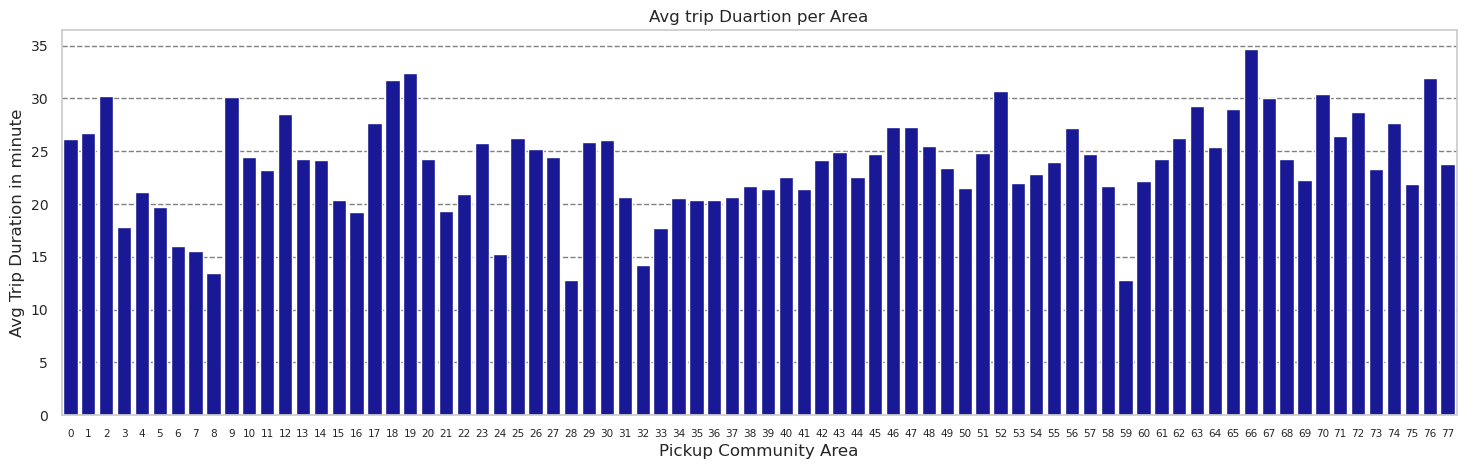

In [19]:
temp = eda.groupBy("Pickup Community Area").agg(F.round(F.avg("Trip Seconds") / 60, 5).alias("Avg Trip Duration in minute"), 
                                                F.round(F.avg("Trip Total"), 5).alias("Avg Total Cost"),
                                                F.round(F.avg("Trip Miles"), 5).alias("Avg Trip Miles"),
                                                F.count("*").alias("Trip Count"))

eda_count = eda.count()
temp = temp.withColumn("Fraction Trip Count", F.round(F.col("Trip Count") / eda_count, 3))
temp_pyspark = temp
temp = temp.toPandas()

size = (18, 5)

plt.figure(figsize = size)
sns.barplot(data = temp, x="Pickup Community Area", 
            y = "Avg Trip Duration in minute", color = 'xkcd:royal blue')
plt.title("Avg trip Duartion per Area")
plt.show()

<br>

 Самые **короткие** поездки в **59-ом регионом**, в то время как самые **продолжительные** поездки приходятся на **66-й регион**.

<br>

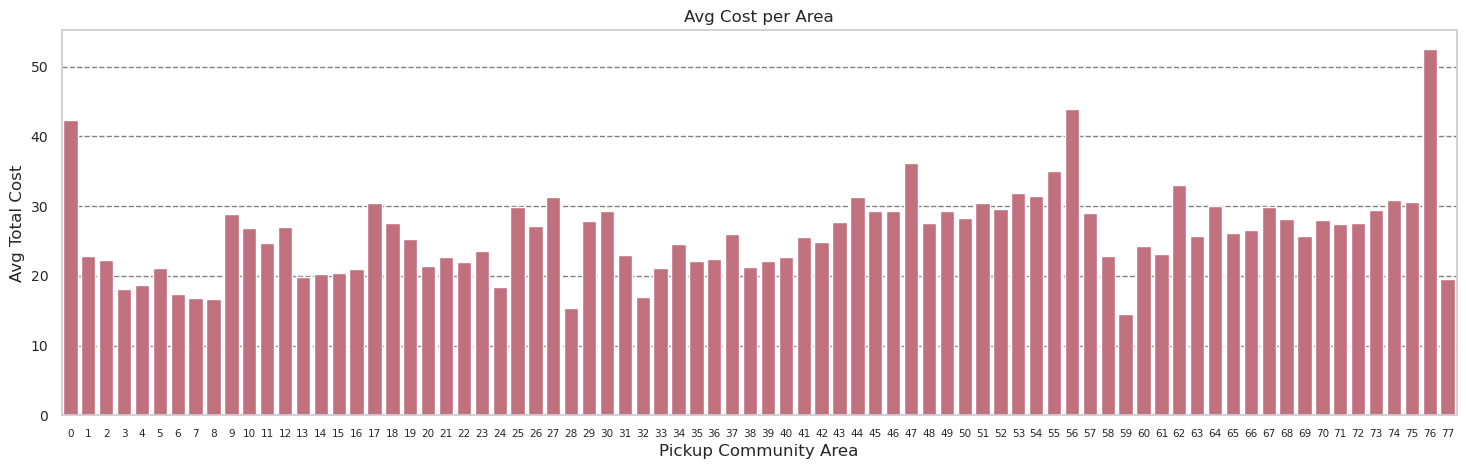

In [20]:
plt.figure(figsize = size)
sns.barplot(data = temp, x="Pickup Community Area", 
            y = "Avg Total Cost", color = 'xkcd:rose')
plt.title("Avg Cost per Area")
plt.show()

<br>

Самые дорогие поездки в **76-ом регионе**, в то время как в **59-ом регионе** самые дешевые. Вероятно, это связано с тем, что в **76-ом регионе** совершаются **не продолжительные поездки**.

Хоть **66-ый регион** и является обладателем **самых длительных поездок**, средняя стоимость поездки **остается на среднем уровне**.


<br>

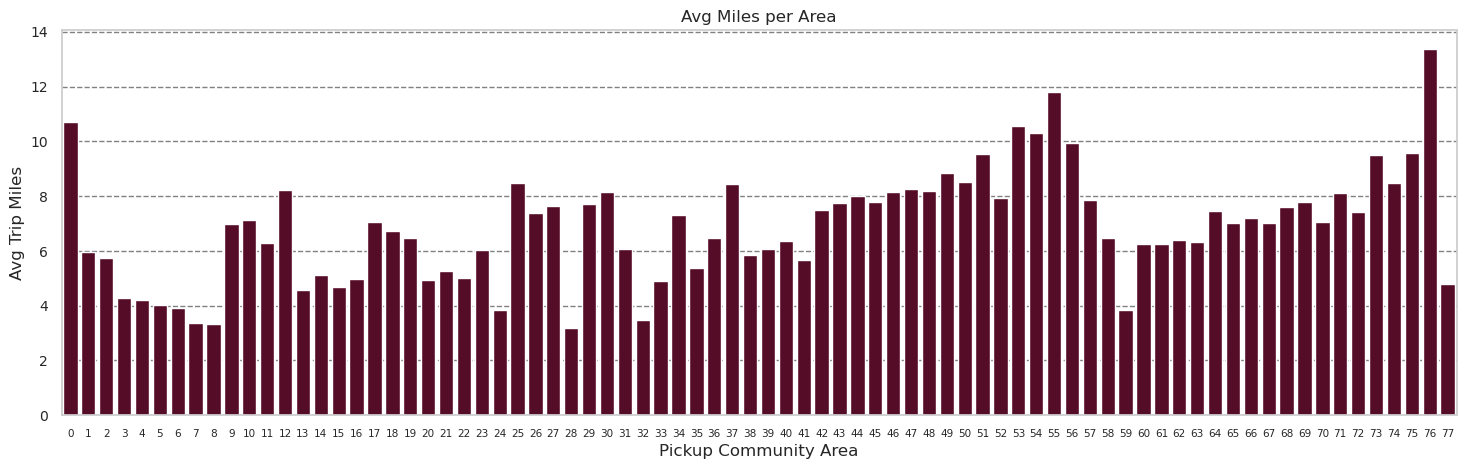

In [21]:
plt.figure(figsize = size)
sns.barplot(data = temp, x="Pickup Community Area", 
            y = "Avg Trip Miles", color = 'xkcd:burgundy')
plt.title("Avg Miles per Area")
plt.show()

<br>

**28-ой регион** обладает самым низким средним расстоянием путешествия, в то время как в **76-ом регионе** оно является самым высоким.

Также мы можем наблюдать **сильно сходство графика с графиком средней стоимости поездки**.

<br>

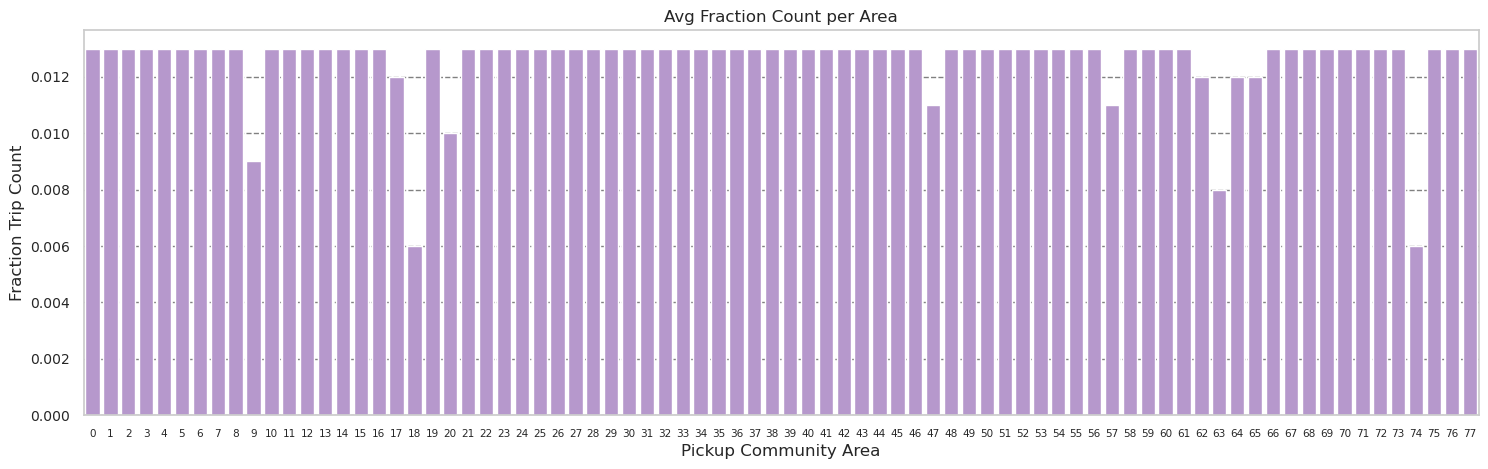

In [22]:
plt.figure(figsize = size)
sns.barplot(data = temp, x="Pickup Community Area", 
            y = "Fraction Trip Count", color = 'xkcd:pale purple')

plt.title("Avg Fraction Count per Area")
plt.show()

<br>

Как **мы видим**, у **некоторых регионов полностью отсутствуют записи за некоторые дни**, то есть, например, в **регионе 18 даже не найдено 5 записей об одном дне**. Это может **свидетельствовать** о том, что **18-ый регион наименее густо населен**, или **люди предпочитают передвигаться на собственных машинах**.

<br>

- **76-ой регион** имеет самую высокую среднюю стоимость поездок, а **59-ый регион** - самую низкую.
- **28-ой регион** характеризуется самым низким средним расстоянием путешествия, в то время как в **76-ом регионе** расстояние поездок оказалось самым высоким.
- Существует сходство между графиком средней стоимости поездок и другими графиками, указывающими на расстояния и продолжительность поездок.


<br>

#### Анализ корреляций средних


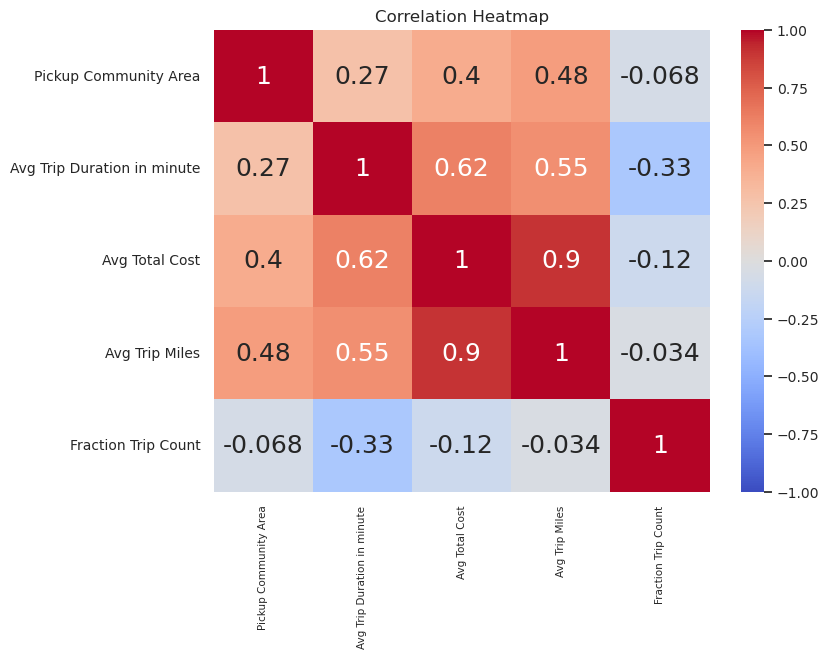

In [23]:
plt.figure(figsize=(8, 6))
sns.heatmap(temp.drop('Trip Count', axis = 1).corr(), 
            annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()

Наиболее заметная **положительная корреляция** наблюдается между "Avg Total Cost" и "Avg Trip Miles" с коэффициентом **0.89**. Это означает, что **более длинные поездки обычно имеют более высокую стоимость**, и наша предположение о сходстве этих двух параметров оказалось верным (*Существует сходство между графиком средней стоимости поездок и другими графиками, указывающими на расстояния и продолжительность поездок.*).

<br>

<br>

In [24]:
del temp, size, temp_pyspark, eda_count

#### Скользящая средняя по регионам

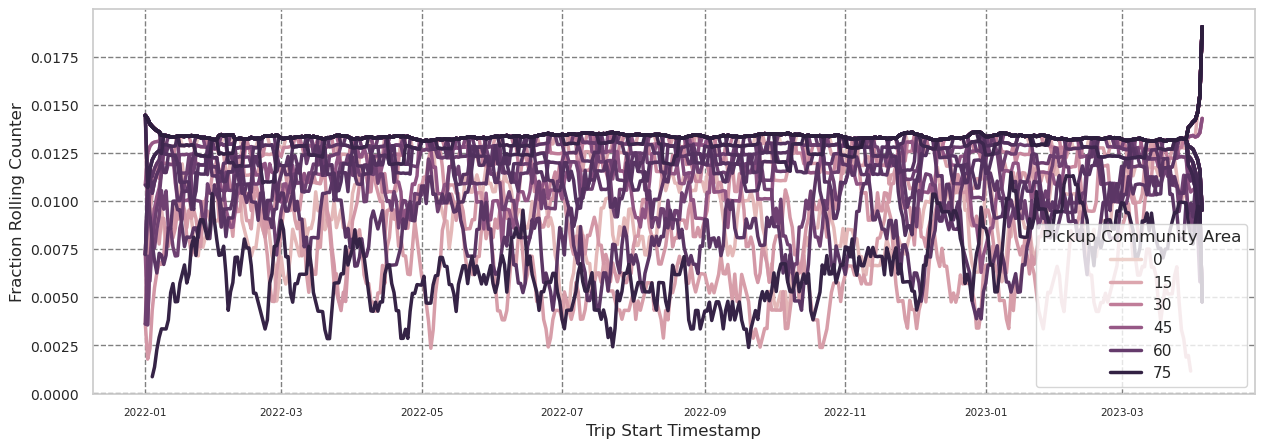

In [25]:
window = F.window(
    F.col("Trip Start Timestamp"),
    windowDuration="7 days",
    slideDuration="1 days",
).alias("window")

temp1 = (eda.groupBy(F.col("Pickup Community Area"), window).agg(F.count(F.col("Trip ID")).alias("Rolling Counter"))
         .withColumn("Trip Start Timestamp", F.date_sub(F.col("window.end").cast("date"), 1)).drop("window"))

temp2 = (eda.groupby(window).agg(F.count(F.col("Trip ID")).alias("Total Counter")).
         withColumn("Trip Start Timestamp", F.date_sub(F.col("window.end").cast("date"), 1)).drop("window"))

temp = temp1.join(temp2, ["Trip Start Timestamp"], how="left").orderBy('Pickup Community Area', 'Trip Start Timestamp')
del temp1, temp2

temp = temp.withColumn('Fraction Rolling Counter', F.col('Rolling Counter') / F.col('Total Counter'))

temp = temp.toPandas()

plt.figure(figsize = (15, 5))
sns.lineplot(data = temp, x = "Trip Start Timestamp", y = "Fraction Rolling Counter", hue = "Pickup Community Area")
plt.show()

<br>

Чтобы сузить фокус анализа, давайте рассмотрим наиболее интересные регионы, которые мы выявили в предыдущем разделе графического анализа средних (#### Графический анализ средних).


<br>

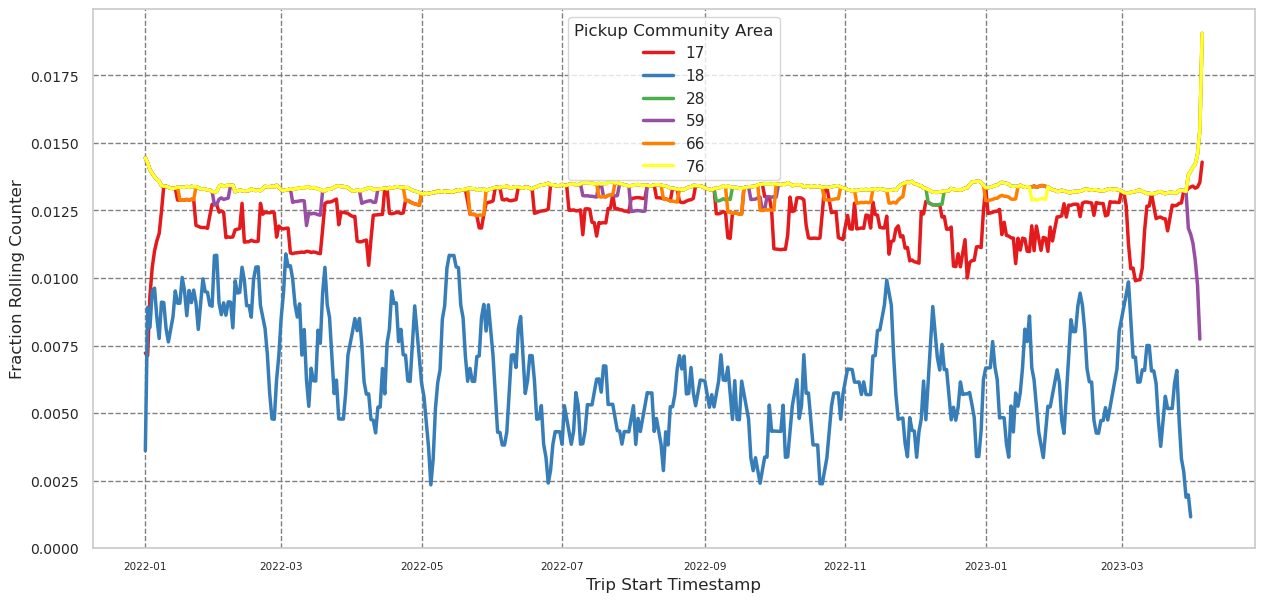

In [26]:
area = [18, 76, 59, 28, 17, 66]

temp = temp[temp["Pickup Community Area"].isin(area)]

plt.figure(figsize = (15, 7))
sns.lineplot(data = temp, x = "Trip Start Timestamp", y = "Fraction Rolling Counter", 
             hue = "Pickup Community Area", palette='Set1')
plt.ylim(ymin=0)
plt.show()

Как можно видеть, 18-ый регион находится ниже из-за малого количества записей по дням, уступая в среднем на 50% от остальных.

Теперь давайте перейдем к рассмотрению изменений при использовании **дневного скользящего счетчика на промежутке с ноября 2022 года по январь 2023**.


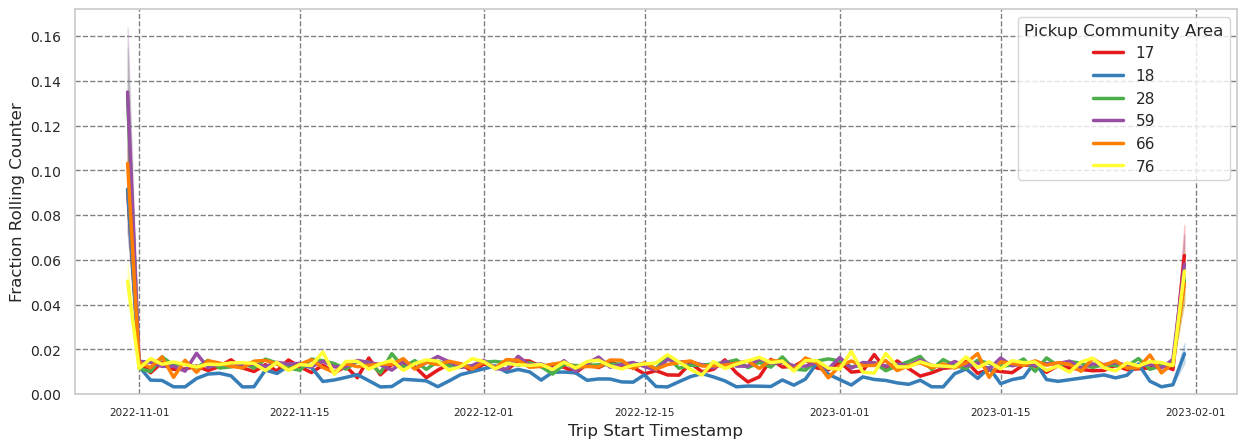

In [27]:
window = F.window(
    F.col("Trip Start Timestamp"),
    windowDuration="1 days",
    slideDuration="1 hours",
).alias("window")

temp0 = eda.filter(F.col('Trip Start Timestamp').between('2022-11', '2023-02'))

temp1 = (temp0.groupBy(F.col("Pickup Community Area"), window).agg(F.count(F.col("Trip ID")).alias("Rolling Counter"))
         .withColumn("Trip Start Timestamp", F.date_sub(F.col("window.end").cast("date"), 1)).drop("window")
)

temp2 = (temp0.groupby(window).agg(F.count(F.col("Trip ID")).alias("Total Counter")).
         withColumn("Trip Start Timestamp", F.date_sub(F.col("window.end").cast("date"), 1)).drop("window")
)

temp = temp1.join(temp2, ["Trip Start Timestamp"], how="left").orderBy('Pickup Community Area', 'Trip Start Timestamp')
del temp1, temp2, temp0

temp = temp.withColumn('Fraction Rolling Counter', F.col('Rolling Counter') / F.col('Total Counter')).filter(F.col('Pickup Community Area').isin(area))

temp = temp.toPandas()

plt.figure(figsize = (15, 5))
sns.lineplot(data = temp, x = "Trip Start Timestamp", y = "Fraction Rolling Counter", 
             hue = "Pickup Community Area", palette='Set1')
plt.ylim(ymin=0)
plt.show()

Как мы можем видеть, **18-ый регион** по-прежнему отстает, но все же бывают пики, когда количество поездок в нем становится больше, и количество сближается с остальными регионами. Эта динамика может быть обусловлена разными факторами. Например, **на промежутке до 2023-01-01 это может быть связано с новым годом**.


In [28]:
del temp, area

/usr/local/spark/python/pyspark/sql/pandas/conversion.py:251: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


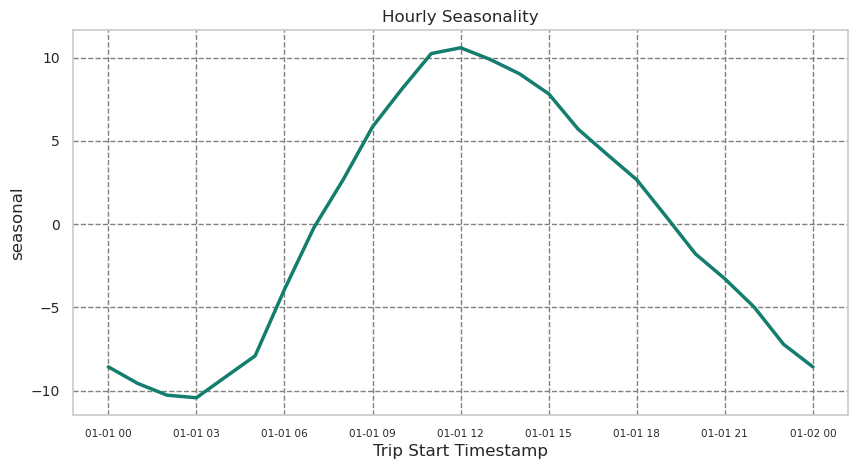

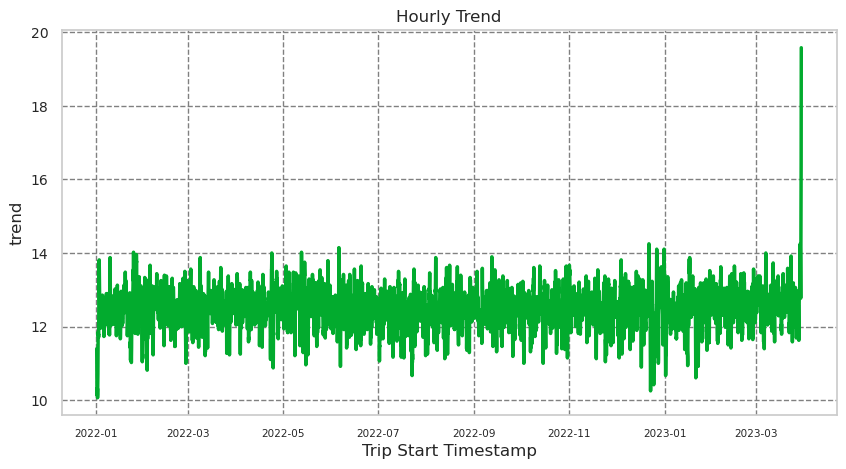

/usr/local/spark/python/pyspark/sql/pandas/conversion.py:251: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


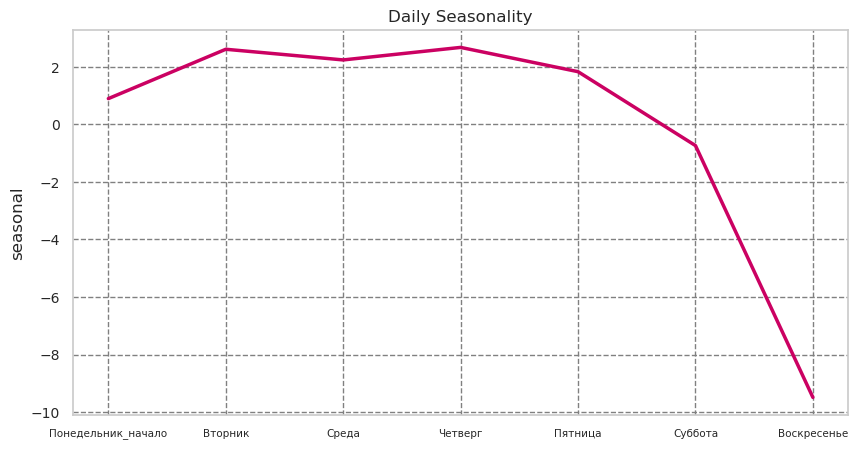

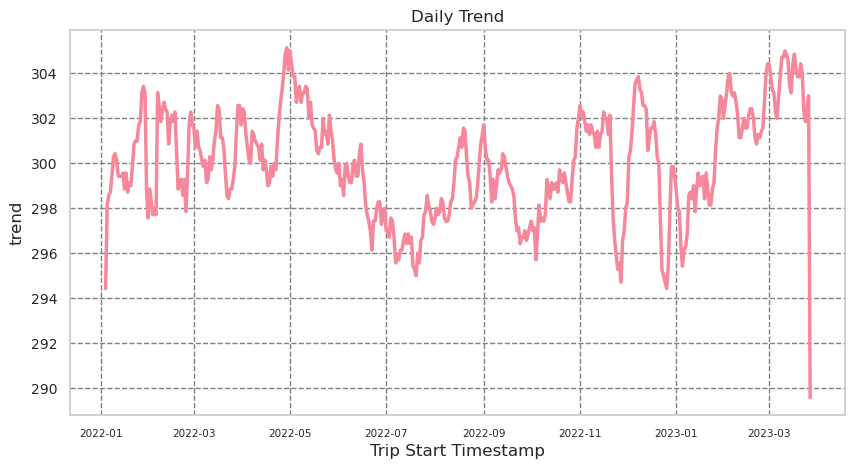

In [29]:
seasonality_types = [
    ("Hourly", ('1 hours', 'h', '1 HOUR','2022-01-01 00:00:00', '2022-01-02 00:00:00', 'xkcd:blue green', 'xkcd:kelly green')),
    ("Daily", ('1 days', 'd', '1 DAY','2022-01-03 00:00:00', '2022-01-09 00:00:00', 'xkcd:deep pink', 'xkcd:rose pink')),
]


for season_type, other in seasonality_types:
    window = F.window(
    F.col("Trip Start Timestamp"),
    windowDuration=other[0],
    slideDuration=other[0],
    ).alias("window")
    
    temp = (eda.groupBy(window).agg(F.count(F.col("Trip ID")).alias("Count"))
            .withColumn("Trip Start Timestamp", F.expr(f"window.end - INTERVAL {other[2]}")).drop("window"))
    temp = temp.orderBy("Trip Start Timestamp").toPandas()
    
    temp['Trip Start Timestamp'] = pd.to_datetime(temp['Trip Start Timestamp'])
    
    temp.set_index("Trip Start Timestamp", inplace = True)
    temp = temp.asfreq(other[1], fill_value = 0)
    
    result = seasonal_decompose(temp, model = "additive")
    sesonal = result.seasonal[other[3]:other[4]]
    if season_type == 'Daily':
        sesonal.index = ["Понедельник_начало", "Вторник", "Среда", "Четверг", "Пятница", 'Суббота', 'Воскресенье']
        
    plt.figure(figsize = (10, 5))
    sns.lineplot(data = sesonal, color = other[5])
    plt.title(f"{season_type} Seasonality")
    plt.show()

    plt.figure(figsize = (10, 5))
    sns.lineplot(data = result.trend, color = other[6])
    plt.title(f"{season_type} Trend")
    plt.show()


<br>

**В ночные часы наблюдается уменьшение числа заказов, в то время как в полдень отмечается пиковая активность заказов.**

**В рабочие дни количество заказов поддерживается на примерно одном уровне, в то время как в выходные дни происходит снижение активности, достигая своего минимума в воскресенье.**

<br>

In [30]:
del seasonality_types, temp, window, result, sesonal, season_type, other, eda

# Preprocessing

In [31]:
# df = df.na.drop(subset = ['Trip Seconds', 'Fare', 'Tips', 'Tolls', 'Extras', 'Trip Total'])
# df = df.na.fill(value = 0, subset = ["Pickup Community Area", "Dropoff Community Area"])

## Агрегация

In [32]:
# window = F.window(
#     F.col("Trip Start Timestamp"),
#     windowDuration='1 hours',
#     slideDuration='1 hours',
#     ).alias("window")


# df = (df.groupBy("Pickup Community Area", window).agg(F.count(F.col("Trip ID")).alias("Trip Count"))
#       .withColumn("Trip Start Timestamp", F.expr(f"window.end - INTERVAL 1 HOUR")).drop("window")
#       .orderBy("Pickup Community Area", "Trip Start Timestamp"))

# df = df.withColumn("Trip Count", F.col("Trip Count").cast('int'))

# df.show(10)

In [33]:
# df.count()

Данных должно быть больше. В течение некоторых дней/часов в некоторых регионах активность не наблюдалась, поэтому дни/часы с нулевой активностью не были включены в таблицу.

In [34]:
# all_dates_df = df.groupBy("Pickup Community Area").agg(
#     F.max('Trip Start Timestamp').alias("max_time"),
#     F.min('Trip Start Timestamp').alias("min_time")
# ).select("Pickup Community Area", F.expr("sequence(min_time, max_time, interval 1 hour)").alias("Trip Start Timestamp")
# ).withColumn("Trip Start Timestamp", F.explode("Trip Start Timestamp"))

# window = Window.partitionBy("Pickup Community Area").orderBy("Trip Start Timestamp")

# df = (all_dates_df.join(df, ["Pickup Community Area", "Trip Start Timestamp"], "left")
#       .orderBy("Pickup Community Area", "Trip Start Timestamp"))

# del all_dates_df

# df = df.na.fill(value = 0, subset = ['Trip Count'])

# df.show()

In [35]:
# df.count()

## Feature engineering

In [36]:
# window = F.window(
#          F.col("Trip Start Timestamp"),
#          windowDuration='24 hours',
#          slideDuration='1 hours',
#          ).alias("DayWindow")

# temp = (df.groupBy("Pickup Community Area", window).agg(F.round(F.avg(F.col("Trip Count")), 3).alias("Trip Rolling AVG 24"),
#                                                         F.sum(F.col("Trip Count")).alias("Trip Rolling Count 24")).withColumn("Trip Start Timestamp", F.expr(f"DayWindow.end - INTERVAL 1 HOUR")).drop("DayWindow").orderBy("Pickup Community Area", "Trip Start Timestamp"))

# temp = temp.withColumn("Trip Rolling Count 24", F.col("Trip Rolling Count 24").cast('int'))

# df = df.join(temp, ["Pickup Community Area", "Trip Start Timestamp"], "left").orderBy("Pickup Community Area", "Trip Start Timestamp")

# df = df.cache()

# window = F.window(
#     F.col("Trip Start Timestamp"),
#     windowDuration="7 days",
#     slideDuration="1 hours",
# ).alias("WeekWindow")

# temp = (df.groupBy("Pickup Community Area", window).agg(F.round(F.avg(F.col("Trip Count")), 3).alias("Trip Rolling AVG day"),
#                                                         F.sum(F.col("Trip Count")).alias("Trip Rolling Count day")).withColumn("Trip Start Timestamp", F.expr(f"WeekWindow.end - INTERVAL 1 HOUR")).drop("WeekWindow").orderBy("Pickup Community Area", "Trip Start Timestamp"))

# temp = temp.withColumn("Trip Rolling Count day", F.col("Trip Rolling Count day").cast('int'))

# df = df.join(temp, ["Pickup Community Area", "Trip Start Timestamp"], "left").orderBy("Pickup Community Area", "Trip Start Timestamp")

# df = df.cache()

In [37]:
# window = Window.partitionBy('Pickup Community Area').orderBy("Trip Start Timestamp")

# lag_intervals = np.arange(1, 24).tolist() + np.arange(24, 24 * 7 + 1, 24).tolist()

# for lag_interval in lag_intervals:
#     lag_col = F.lag(F.col("Trip Count"), offset = lag_interval).over(window)
#     new_col_name = f"lag_{lag_interval}h" if lag_interval < 24 else f"lag_{lag_interval // 24}d"
#     df = df.withColumn(new_col_name, lag_col)

# df = df.cache()

# df = df.filter(F.col('Trip Start Timestamp') > '2022-01-12').orderBy('Pickup Community Area', 'Trip Start Timestamp')


# df = df.withColumn("Year", F.year("Trip Start Timestamp"))
# df = df.withColumn("Month", F.month("Trip Start Timestamp"))
# df = df.withColumn("Day", F.dayofmonth("Trip Start Timestamp"))
# df = df.withColumn("Hour", F.hour("Trip Start Timestamp"))
# df = df.withColumn("Week Of Year", F.weekofyear("Trip Start Timestamp"))
# df = df.withColumn("Day Of Week", F.dayofweek("Trip Start Timestamp"))

# df = df.drop("Trip Start Timestamp")

# df = df.cache()

# df.show()

# del lag_intervals, lag_col, new_col_name, lag_interval, temp

In [38]:
# print("Start write!")
# df.write.option("header", True).csv("Processed")

In [39]:
cached_df_ids = [id(df) for df in spark.catalog.listTables()]
for df_id in cached_df_ids:
    spark.catalog.uncacheTable(df_id)

cached_df_ids
del cached_df_ids

In [43]:
custom_schema = StructType([
        StructField('Pickup Community Area', IntegerType(), True),
        StructField('Trip Count', IntegerType(), True),
    
        StructField('Trip Rolling AVG 24', DoubleType(), True),
        StructField('Trip Rolling Count 24', IntegerType(), True),
        StructField('Trip Rolling AVG day', DoubleType(), True),
        StructField('Trip Rolling Count day', IntegerType(), True),
    
        StructField('lag_1h', IntegerType(), True),
        StructField('lag_2h', IntegerType(), True),
        StructField('lag_3h', IntegerType(), True),
        StructField('lag_4h', IntegerType(), True),
        StructField('lag_5h', IntegerType(), True),
        StructField('lag_6h', IntegerType(), True),
        StructField('lag_7h', IntegerType(), True),
        StructField('lag_8h', IntegerType(), True),
        StructField('lag_9h', IntegerType(), True),
        StructField('lag_10h', IntegerType(), True),
        StructField('lag_11h', IntegerType(), True),
        StructField('lag_12h', IntegerType(), True),
        StructField('lag_13h', IntegerType(), True),
        StructField('lag_14h', IntegerType(), True),
        StructField('lag_15h', IntegerType(), True),
        StructField('lag_16h', IntegerType(), True),
        StructField('lag_17h', IntegerType(), True),
        StructField('lag_18h', IntegerType(), True),
        StructField('lag_19h', IntegerType(), True),
        StructField('lag_20h', IntegerType(), True),
        StructField('lag_21h', IntegerType(), True),
        StructField('lag_22h', IntegerType(), True),
        StructField('lag_23h', IntegerType(), True),
        StructField('lag_1d', IntegerType(), True),
        StructField('lag_2d', IntegerType(), True),
        StructField('lag_3d', IntegerType(), True),
        StructField('lag_4d', IntegerType(), True),
        StructField('lag_5d', IntegerType(), True),
        StructField('lag_6d', IntegerType(), True),
        StructField('lag_7d', IntegerType(), True),
        StructField('Year', IntegerType(), True),
        StructField('Month', IntegerType(), True),
        StructField('Day', IntegerType(), True),
        StructField('Hour', IntegerType(), True),
        StructField('Week Of Year', IntegerType(), True),
        StructField('Day Of Week', IntegerType(), True)
        ])

In [44]:
df = spark.read.csv('Processed', sep=",", header='true', schema=custom_schema)
df.show(5)
df.count()

+---------------------+----------+-------------------+---------------------+--------------------+----------------------+------+------+------+------+------+------+------+------+------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+------+------+------+------+------+------+------+----+-----+---+----+------------+-----------+
|Pickup Community Area|Trip Count|Trip Rolling AVG 24|Trip Rolling Count 24|Trip Rolling AVG day|Trip Rolling Count day|lag_1h|lag_2h|lag_3h|lag_4h|lag_5h|lag_6h|lag_7h|lag_8h|lag_9h|lag_10h|lag_11h|lag_12h|lag_13h|lag_14h|lag_15h|lag_16h|lag_17h|lag_18h|lag_19h|lag_20h|lag_21h|lag_22h|lag_23h|lag_1d|lag_2d|lag_3d|lag_4d|lag_5d|lag_6d|lag_7d|Year|Month|Day|Hour|Week Of Year|Day Of Week|
+---------------------+----------+-------------------+---------------------+--------------------+----------------------+------+------+------+------+------+------+------+------+------+-------+-------+-------+-------+-----

827681

In [45]:
df = df.drop('Trip Rolling AVG 24', 'Trip Rolling Count 24', 'Trip Rolling AVG day', 'Trip Rolling Count day')

df = df.withColumn("date_column", F.to_date(F.concat_ws("-", F.col("Year"),F.lpad(F.col("Month"), 2, "0"), 
                                                        F.lpad(F.col("Day"), 2, "0")), "yyyy-MM-dd"))
df.show(10)

(df.select(F.max('date_column').alias('max'), F.min('date_column').alias('min'))
 .select('min', 'max', F.datediff(F.col('max'), F.col('min')).alias('Days between max and min')).show())

train_data = df.filter(F.col("date_column").between('2022-01-12', '2023-01-10'))
valid_data = df.filter(F.col("date_column").between('2023-01-11', '2023-02-20'))
test_data = df.filter(F.col("date_column").between('2023-02-21', '2023-03-30'))


del df

train_data = train_data.drop('date_column')
test_data = test_data.drop('date_column')
valid_data = valid_data.drop('date_column')

print("\n\n\nTrain")
train_data.show(5)
print("\n\n\nValid")
valid_data.show(5)
print("\n\n\nTest")
test_data.show(5)

+---------------------+----------+------+------+------+------+------+------+------+------+------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+------+------+------+------+------+------+------+----+-----+---+----+------------+-----------+-----------+
|Pickup Community Area|Trip Count|lag_1h|lag_2h|lag_3h|lag_4h|lag_5h|lag_6h|lag_7h|lag_8h|lag_9h|lag_10h|lag_11h|lag_12h|lag_13h|lag_14h|lag_15h|lag_16h|lag_17h|lag_18h|lag_19h|lag_20h|lag_21h|lag_22h|lag_23h|lag_1d|lag_2d|lag_3d|lag_4d|lag_5d|lag_6d|lag_7d|Year|Month|Day|Hour|Week Of Year|Day Of Week|date_column|
+---------------------+----------+------+------+------+------+------+------+------+------+------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+------+------+------+------+------+------+------+----+-----+---+----+------------+-----------+-----------+
|                   32|       126|   131|   122|    

# Моделирование

## Заполнение предыдущим членом ряда

In [55]:
temp = valid_data.select('Pickup Community Area', 'Trip Count', 'Year', 'Month', 'Day', 'Hour')
temp = temp.withColumn("Date Time", 
                   F.to_timestamp(
                       F.concat_ws("-", F.col("Year"), F.lpad(F.col("Month"), 2, "0"),
                                   F.lpad(F.col("Day"), 2, "0"), F.lpad(F.col("Hour"), 2, "0")), 
                       "yyyy-MM-dd-HH"))
temp = temp.select('Pickup Community Area', 'Date Time', "Trip Count")
temp.show()

+---------------------+-------------------+----------+
|Pickup Community Area|          Date Time|Trip Count|
+---------------------+-------------------+----------+
|                   32|2023-01-11 00:00:00|         5|
|                   32|2023-01-11 01:00:00|         6|
|                   32|2023-01-11 02:00:00|         0|
|                   32|2023-01-11 03:00:00|         2|
|                   32|2023-01-11 04:00:00|         5|
|                   32|2023-01-11 05:00:00|        15|
|                   32|2023-01-11 06:00:00|        32|
|                   32|2023-01-11 07:00:00|        96|
|                   32|2023-01-11 08:00:00|       174|
|                   32|2023-01-11 09:00:00|       135|
|                   32|2023-01-11 10:00:00|        97|
|                   32|2023-01-11 11:00:00|       152|
|                   32|2023-01-11 12:00:00|       152|
|                   32|2023-01-11 13:00:00|       162|
|                   32|2023-01-11 14:00:00|       189|
|         

In [56]:
window = Window.partitionBy('Pickup Community Area').orderBy("Date Time")

lead_col = F.lag(F.col("Trip Count"), offset=1).over(window)
temp = temp.withColumn('Lag Count', lead_col)
temp = temp.filter(F.col('Date Time') > '2023-01-11 00:00:00')

temp.show()

+---------------------+-------------------+----------+---------+
|Pickup Community Area|          Date Time|Trip Count|Lag Count|
+---------------------+-------------------+----------+---------+
|                    0|2023-01-11 01:00:00|         5|       10|
|                    0|2023-01-11 02:00:00|         0|        5|
|                    0|2023-01-11 03:00:00|         1|        0|
|                    0|2023-01-11 04:00:00|         6|        1|
|                    0|2023-01-11 05:00:00|        15|        6|
|                    0|2023-01-11 06:00:00|        21|       15|
|                    0|2023-01-11 07:00:00|        31|       21|
|                    0|2023-01-11 08:00:00|        42|       31|
|                    0|2023-01-11 09:00:00|        40|       42|
|                    0|2023-01-11 10:00:00|        50|       40|
|                    0|2023-01-11 11:00:00|        49|       50|
|                    0|2023-01-11 12:00:00|        58|       49|
|                    0|20

In [57]:
temp = temp.drop('Date Time').toPandas()

print('MAE', metrics.mean_absolute_error(temp['Trip Count'], temp['Lag Count']))

results_lag = {'MAPE':[], 'MAE':[]}
areas = temp['Pickup Community Area'].unique()

for area in areas:
    (results_lag["MAPE"].append(metrics.mean_absolute_percentage_error(temp[temp['Pickup Community Area'] == area]
    ['Trip Count'], temp[temp['Pickup Community Area'] == area]['Lag Count'])))
    (results_lag["MAE"].append(metrics.mean_absolute_error(temp[temp['Pickup Community Area'] == area]
    ['Trip Count'], temp[temp['Pickup Community Area'] == area]['Lag Count'])))

temp = pd.DataFrame(results_lag)
temp = temp.reset_index().rename(columns = {'index':'Pickup Community Area'})

MAE 2.6441949030962255


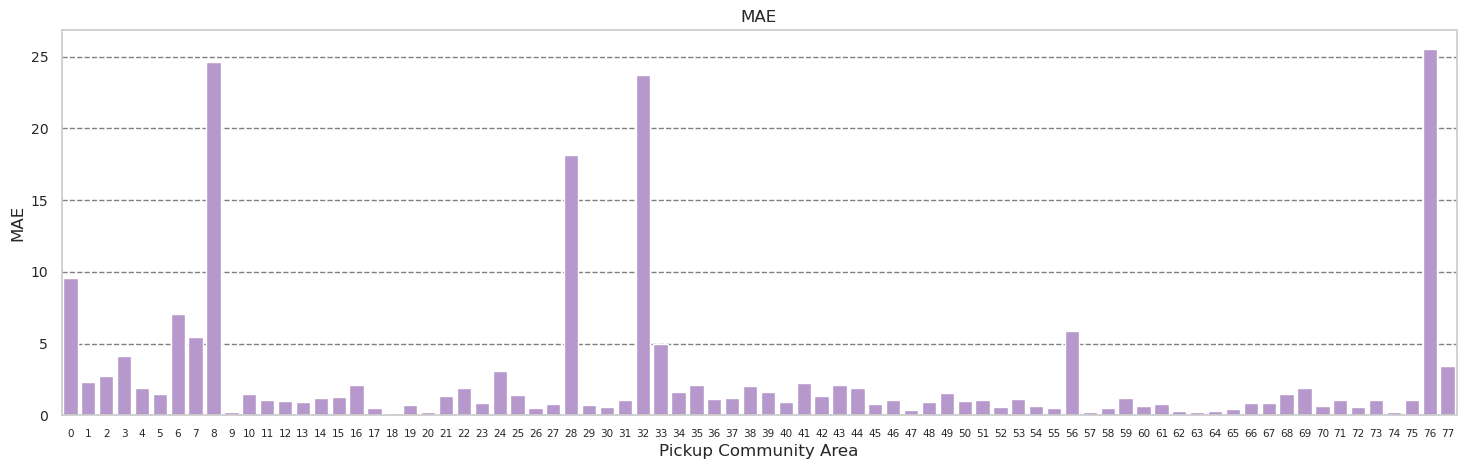

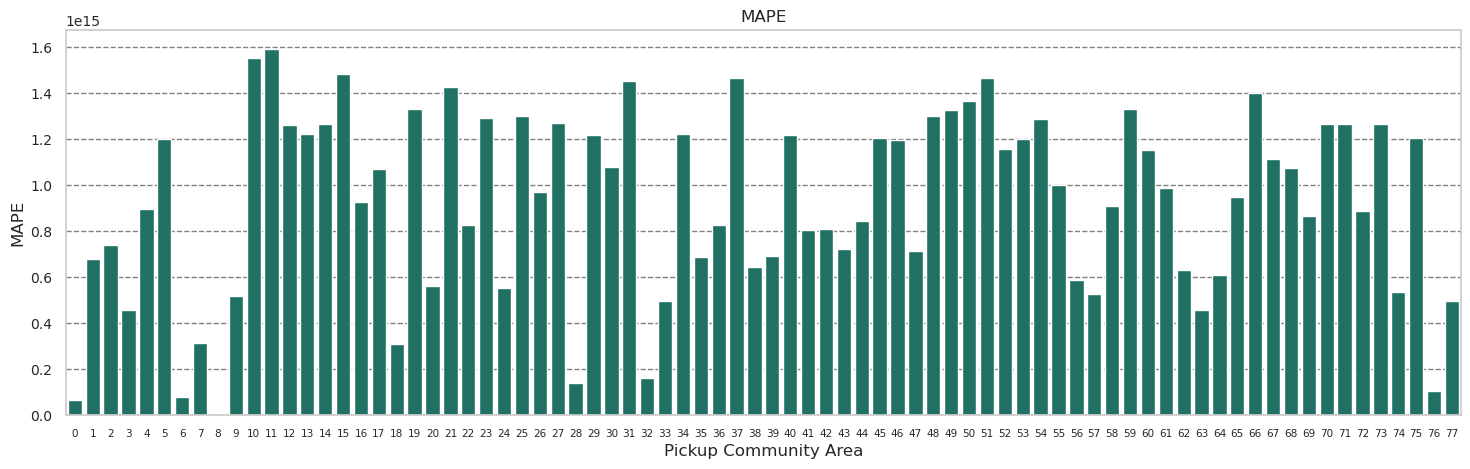

In [54]:
for i in ['MAE', 'MAPE']:
    color = 'xkcd:pale purple'
    if i == 'MAPE':
        color = 'xkcd:blue green'
        
    plt.figure(figsize = (18,5))
    sns.barplot(data = temp, x="Pickup Community Area", 
                y = i, color = color)
    plt.title(i)
    plt.show()

Из-за неравномерного распределения количества поездок между различными районами, средняя абсолютная ошибка (MAE) оказалась выше в тех регионах, где общее количество поездок было значительно больше, и ниже в регионах с меньшим общим числом поездок. Однако процентная абсолютная ошибка (MAPE) оказалась выше в регионах с меньшим общим количеством поездок, в то время как в регионах с более высоким общим количеством поездок MAPE была ниже.

## Линейная регрессия.

In [72]:
feature_columns = train_data.columns
feature_columns.pop(1)

assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
assembled_train = assembler.transform(train_data)
assembled_valid = assembler.transform(valid_data)

assembled_train.show(1)

+---------------------+----------+------+------+------+------+------+------+------+------+------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+------+------+------+------+------+------+------+----+-----+---+------------+-------------------+-------------------+-------------------+-------------------+--------------------+
|Pickup Community Area|Trip Count|lag_1h|lag_2h|lag_3h|lag_4h|lag_5h|lag_6h|lag_7h|lag_8h|lag_9h|lag_10h|lag_11h|lag_12h|lag_13h|lag_14h|lag_15h|lag_16h|lag_17h|lag_18h|lag_19h|lag_20h|lag_21h|lag_22h|lag_23h|lag_1d|lag_2d|lag_3d|lag_4d|lag_5d|lag_6d|lag_7d|Year|Month|Day|Week Of Year|              HourC|              HourS|       Day of WeekC|       Day of WeekS|            features|
+---------------------+----------+------+------+------+------+------+------+------+------+------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+------+------+-

In [59]:
lr = LinearRegression(featuresCol="features", labelCol="Trip Count")
lr = lr.fit(assembled_train)

predictions = lr.transform(assembled_valid)

predictions.show(3)

+---------------------+----------+------+------+------+------+------+------+------+------+------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+------+------+------+------+------+------+------+----+-----+---+----+------------+-----------+--------------------+-------------------+
|Pickup Community Area|Trip Count|lag_1h|lag_2h|lag_3h|lag_4h|lag_5h|lag_6h|lag_7h|lag_8h|lag_9h|lag_10h|lag_11h|lag_12h|lag_13h|lag_14h|lag_15h|lag_16h|lag_17h|lag_18h|lag_19h|lag_20h|lag_21h|lag_22h|lag_23h|lag_1d|lag_2d|lag_3d|lag_4d|lag_5d|lag_6d|lag_7d|Year|Month|Day|Hour|Week Of Year|Day Of Week|            features|         prediction|
+---------------------+----------+------+------+------+------+------+------+------+------+------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+------+------+------+------+------+------+------+----+-----+---+----+------------+-----------+-------

In [61]:
temp = predictions.select('Pickup Community Area', 'Trip Count', "prediction").toPandas()

print('MAE', metrics.mean_absolute_error(temp['Trip Count'], temp['prediction']))

results_lr = {'MAPE':[], 'MAE':[]}
areas = temp['Pickup Community Area'].unique()

for area in areas:
    (results_lr["MAPE"].append(metrics.mean_absolute_percentage_error(temp[temp['Pickup Community Area'] == area]
    ['Trip Count'], temp[temp['Pickup Community Area'] == area]['prediction'])))
    (results_lr["MAE"].append(metrics.mean_absolute_error(temp[temp['Pickup Community Area'] == area]
    ['Trip Count'], temp[temp['Pickup Community Area'] == area]['prediction'])))

temp = pd.DataFrame(results_lr)
temp = temp.reset_index().rename(columns = {'index':'Pickup Community Area'})

MAE 2.0816306889872553


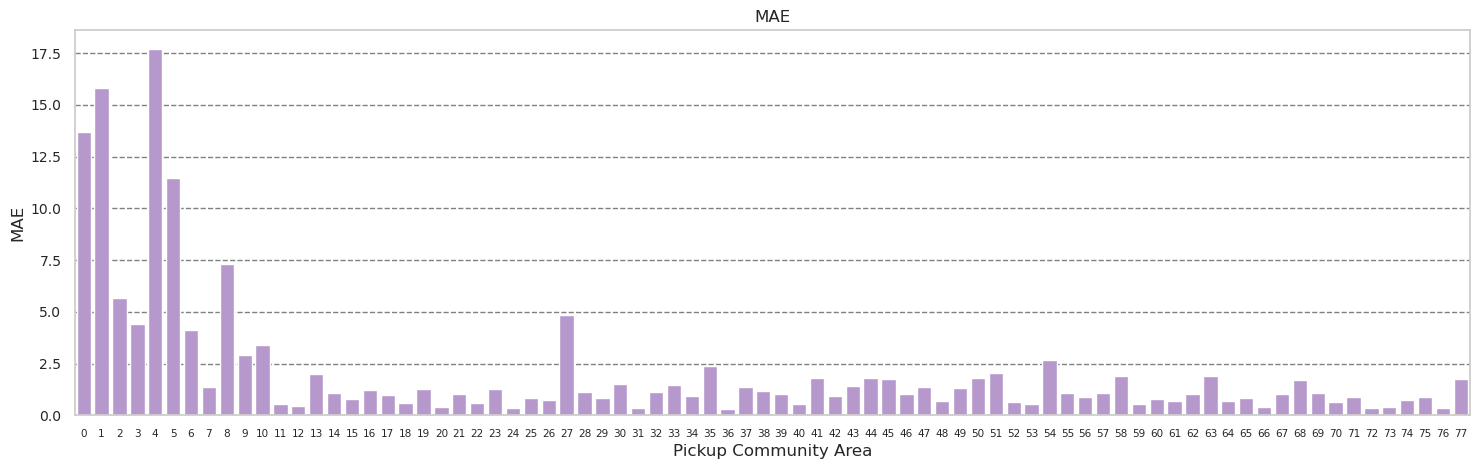

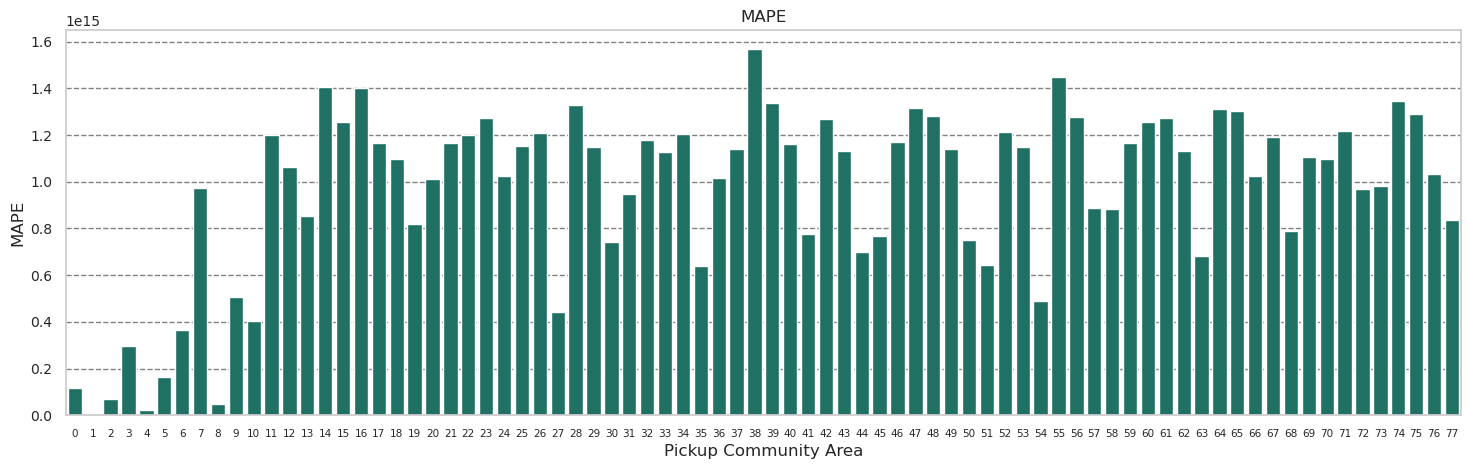

In [62]:
for i in ['MAE', 'MAPE']:
    color = 'xkcd:pale purple'
    if i == 'MAPE':
        color = 'xkcd:blue green'
        
    plt.figure(figsize = (18,5))
    sns.barplot(data = temp, x="Pickup Community Area", 
                y = i, color = color)
    plt.title(i)
    plt.show()

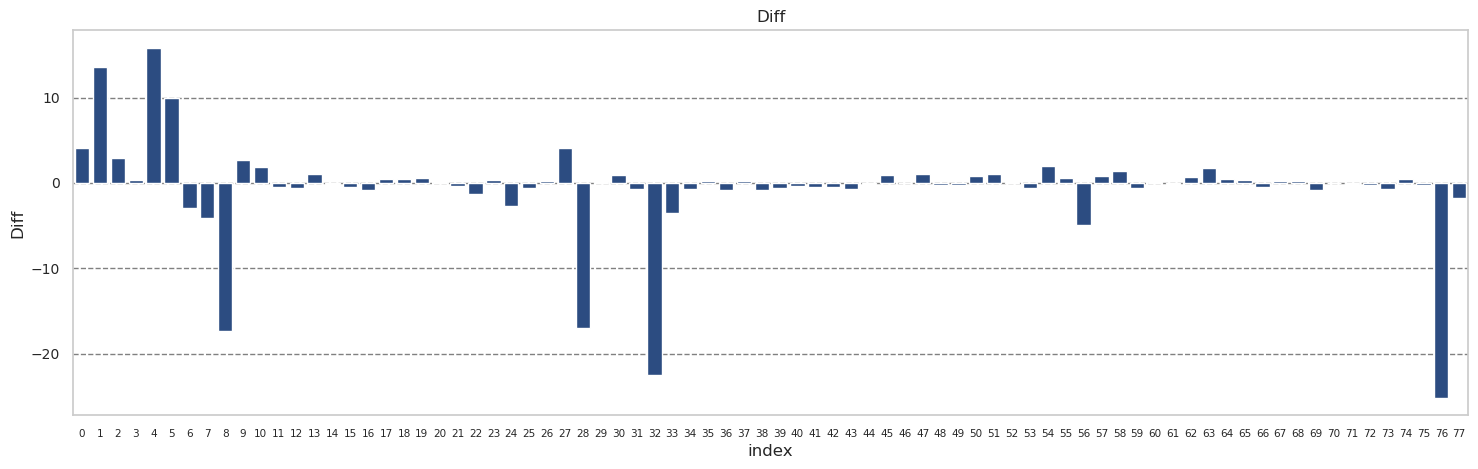

In [63]:
diff = np.array(results_lr['MAE']) - np.array(results_lag['MAE'])
temp = pd.DataFrame({'Diff': diff}).reset_index()

color = 'xkcd:cobalt'    
plt.figure(figsize = (18,5))
sns.barplot(data = temp, x="index", 
            y = 'Diff', color = color)
plt.title('Diff')
plt.show()

В целом, разница между прогнозами, полученными с использованием обоих методов, невелика, за исключением 76-го региона, где линейная регрессия привела к более значительному отклонению прогнозов от фактических значений.

MAE и MAPE также демонстрируют схожие результаты для обоих методов прогнозирования, и разница между ними незначительна.

In [ ]:
del (area, areas, assembled_train, assembled_valid, color, 
     custom_schema, diff, feature_columns, i, lead_col, 
     predictions, temp, window)

## Проверка на тесте.

MAE 2.416181604068454
MAPE 1020626397753404.4


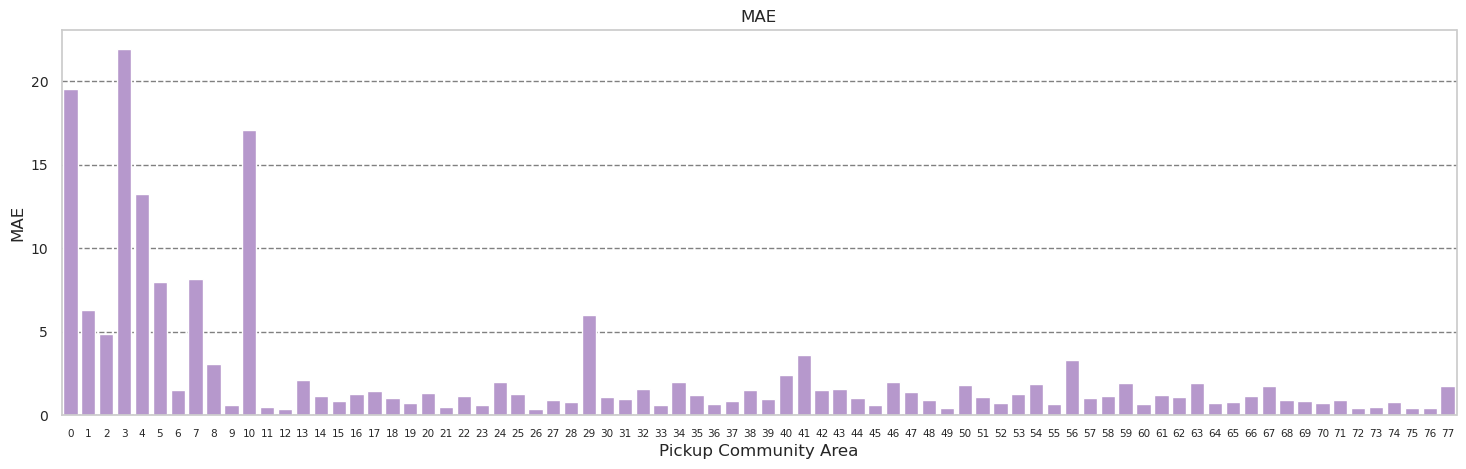

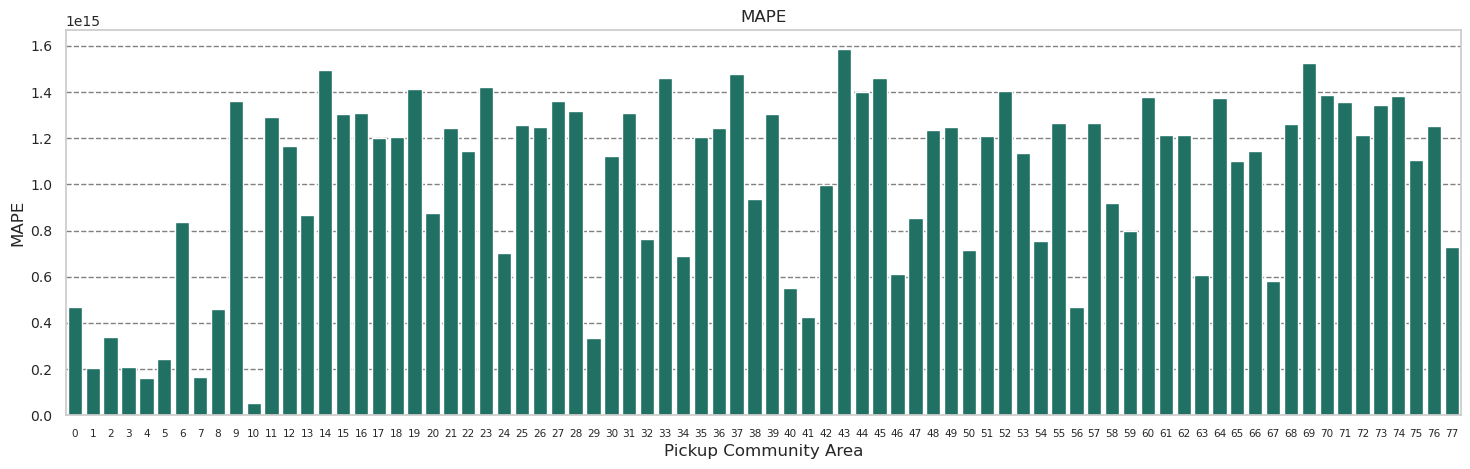

In [74]:
assembled_test = assembler.transform(test_data)
temp = lr.transform(assembled_test).select('Pickup Community Area', 'Trip Count', "prediction").toPandas()

print('MAE', metrics.mean_absolute_error(temp['Trip Count'], temp['prediction']))
print('MAPE', metrics.mean_absolute_percentage_error(temp['Trip Count'], temp['prediction']))

results_lr = {'MAPE':[], 'MAE':[]}
areas = temp['Pickup Community Area'].unique()

for area in areas:
    (results_lr["MAPE"].append(metrics.mean_absolute_percentage_error(temp[temp['Pickup Community Area'] == area]
    ['Trip Count'], temp[temp['Pickup Community Area'] == area]['prediction'])))
    (results_lr["MAE"].append(metrics.mean_absolute_error(temp[temp['Pickup Community Area'] == area]
    ['Trip Count'], temp[temp['Pickup Community Area'] == area]['prediction'])))

temp = pd.DataFrame(results_lr)
temp = temp.reset_index().rename(columns = {'index':'Pickup Community Area'})

for i in ['MAE', 'MAPE']:
    color = 'xkcd:pale purple'
    if i == 'MAPE':
        color = 'xkcd:blue green'
        
    plt.figure(figsize = (18,5))
    sns.barplot(data = temp, x="Pickup Community Area", 
                y = i, color = color)
    plt.title(i)
    plt.show()

Ошибка на тестовых данных составляет 2.4, что является очень хорошим результатом. Однако из-за неравномерного количества поездок в разных районах нельзя сделать точные выводы о качестве. 

# Вывод

В ходе этого проекта по прогнозированию количества заказов такси в городе Чикаго, мы провели анализ данных и разработали модель прогнозирования. Давайте подведем итоги:

1. Мы начали с подготовки и анализа исходных данных о заказах такси. Проведя визуальный, мы идентифицировали временные паттерны, влияющие на спрос.

2. На этапе моделирования, мы выбрали подходящий метод, создали признаки для модели и разделили данные на обучающую и тестовую выборки. Затем мы обучили модель, оценили ее производительность.

3. Наша модель прогнозирования количества заказов такси продемонстрировала приемлимою точность и способность учитывать временные паттерны.

4. Результаты проекта могут быть использованы такси-компаниями для оптимизации ресурсов и улучшения обслуживания клиентов. Наши рекомендации помогут лучше управлять флотом такси в зависимости от времени суток, дня недели и сезонных колебаний спроса.

5. Прогнозирование спроса на такси - это сложная задача, но с использованием анализа данных и современных методов машинного обучения, мы можем сделать это более эффективно и удовлетворить потребности клиентов.